In [44]:
# default_exp core

# simple_interpolation

> Interpolation rocks, but it can screw the original features of your data series if done poorly. One algorithm that at least preserves the original volatility is **Brownian Bridge**, which uses it as an input. This is an implementation of the Brownian Bridge to be used with **Pandas**.

In [1]:
#hide
from nbdev.showdoc import *

In [2]:
#export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import is_datetime64_any_dtype as is_datetime

## interpolate_gaps()

In [3]:
#export
def interpolate_gaps(df_to_patch, method = 'wiener', fixed_freq = 'min', plot = False):
    """
    Searches for gaps and interpolates with a Brownian Bridge,
    which preserves volatility of the whole trend.

    ::returns:: patched, interpolated DataFrame with 3 columns:
                    "X_original_name", 
                    "Y_original_name",
                    "interpolated" (flag to mark interpolated rows)
    """

    # Check DataFrame is well formated and identifies X,Y columns
    dataframe_valid, params_deduced = check_dataframe(df_to_patch)  
    if dataframe_valid:
        x_column = params_deduced['x_column']
        y_column = params_deduced['y_column']
        datetime_present = params_deduced['datetime_flag']
    else:
        raise Exception(f'DataFrame did not pass the check_dataframe() tests. Check previous logs')
    
    # std generation method validation
    if method == 'wiener':
        print("std() built with Wiener method")
    elif method == 'local_scan':
        print("std() built with local_scan method")
    else:
        raise Exception(f"ERROR: 'method' argument must be 'wiener' (default) or 'local_scan', but got {method}")  
    
    # Detecting gaps and labeling them
    
    # Drop NaNs, if any, so we treat them as proper gaps
    df_to_patch = df_to_patch.dropna()

    # Reset index (we need a continous one for this algorithm! Otherwise .iloc[] can go crazy)
    df_to_patch = df_to_patch.reset_index().drop(columns=['index'])
    
    # Fast way to calculate deltas: adding shifted column, so we calculate delta on same row (fast)
    # global df_shift
    df_shift = df_to_patch.copy()
    df_shift[x_column + '_shift'] = df_shift[x_column].shift(1)
    df_shift['x_deltas'] =  df_shift[x_column] - df_shift[x_column + '_shift']
    expected_gap = df_shift['x_deltas'].mean()
    # gap_deviation = df_shift['x_deltas'].std()
    
    # Add column with "gap?" flags
    if datetime_present:
        interval = expected_gap.total_seconds()*1.01 # maybe turn this into a parameter ("sensibility"?)
        params_deduced['interval'] = interval
        df_shift['gap?'] = df_shift['x_deltas'].apply(lambda x: 1 if x.total_seconds() > interval else 0)
    else:
        interval = expected_gap*1.01 # maybe turn this into a parameter ("sensibility"?)
        params_deduced['interval'] = interval
        df_shift['gap?'] = df_shift['x_deltas'].apply(lambda x: 1 if x > interval else 0)
    
    # Gap indexes to attack
    gap_indexes = df_shift.index[df_shift['gap?'] == 1].tolist()

    # Print interval threshold (so user can see if it looks good)
    print(f"Will interpolate if X-column interval is more than {interval}")

    # Patch collection
    patch_collection = []
    
    for gap_index in gap_indexes:    
        # Loadbar
        if gap_indexes.index(gap_index) % 50 == 0:
            perc = (gap_indexes.index(gap_index) / len(gap_indexes))*100
            print(f"Processed "+"{:.2f}".format(perc) + "% of gaps")

        # Relevant rows
        current_row = df_to_patch.iloc[gap_index]
        previous_row = df_to_patch.iloc[gap_index - 1]
        delta = current_row[x_column] - previous_row[x_column]
        if datetime_present:
            delta_in_float = delta.total_seconds()
        else:
            delta_in_float = delta
        
         # If finds gap
        if delta_in_float > interval:
            # Interpolate
            interpolated = []
            x0, y0 = previous_row[x_column], previous_row[y_column]
            x1, y1 = current_row[x_column], current_row[y_column]
            local_std = get_local_std(delta, df_to_patch, params_deduced, gap_index, method = method)
            local_variance = local_std * local_std
            bb(x0, y0, x1, y1, params_deduced, local_variance, interpolated, fixed_freq)

            # From list of tuples to df
            inter_df = pd.DataFrame(interpolated, columns = [x_column, y_column])
            inter_df = inter_df.sort_values(by=[x_column])
            inter_df['interpolated'] = 1            

            # Add to patch collection
            patch_collection.append(inter_df)
            
    # Patch original, re-sort on X-column, drop old index
    df_to_patch['interpolated'] = 0
    patched = df_to_patch
    for patch in patch_collection:
        patched = pd.concat([patched, patch])
    patched = patched.sort_values(by=[x_column])
    patched = patched.reset_index().drop(columns=['index'])

    # Plotting results if asked for it
    if plot:
        print("Ended interpolation, starting plotting the results..")
        plot_results(patched)
    else:
        print("Ended succesfully")
   
    print("Ended execution")
    return patched

In [12]:
# hide
x = list(range(0,50))
y = [np.random.normal(loc = 10.0, scale = 1.5) for _ in x]

# Delete some points
points_to_remove = [3,4,5,17,18]
points_to_remove.extend(list(range(29,45)))
# points_to_remove.extend(list(range(55,60)))
# points_to_remove.extend(list(range(70,95)))
for removal in points_to_remove:
    i = x.index(removal)
    x.remove(removal)
    y.remove(y[i])
    
df = pd.DataFrame(list(zip(x, y)), 
               columns =['X', 'Y']) 

In [13]:
# Example dataframe
df

,X,Y
0,0,10.055026
1,1,9.068303
2,2,11.715802
3,6,10.544049
4,7,11.173205
5,8,10.990786
6,9,10.036450
7,10,9.229775
8,11,12.984173
9,12,10.048657


No datetime column: assuming first column 'X' as X-axis
std() built with Wiener method
Will interpolate if X-column interval is more than 1.7675
Processed 0.00% of gaps
Ended interpolation, starting plotting the results..


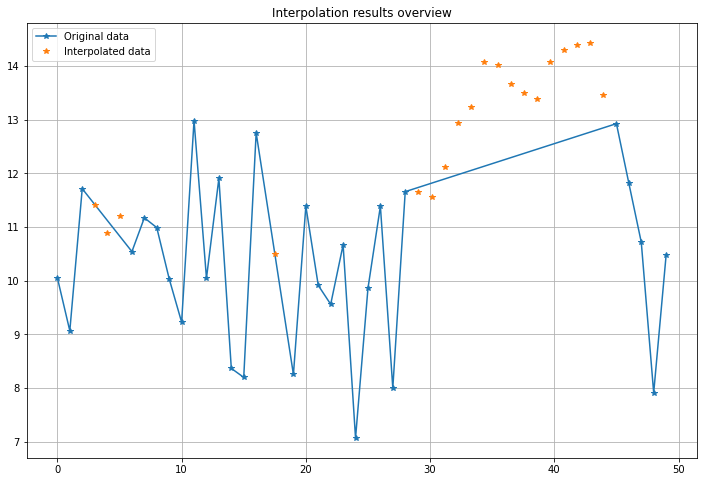

Ended execution


,X,Y,interpolated
0,0.0000,10.055026,0
1,1.0000,9.068303,0
2,2.0000,11.715802,0
3,3.0000,11.410472,1
4,4.0000,10.895129,1
5,5.0000,11.213533,1
6,6.0000,10.544049,0
7,7.0000,11.173205,0
8,8.0000,10.990786,0
9,9.0000,10.036450,0


In [14]:
# Interpolation
patched_df = interpolate_gaps( df , plot = True )
patched_df

In [5]:
#exporti
def check_dataframe(df):
    """
    Collection of tests done first on the dataframe
    to ensure it's properly formatted for interpolation,
    and identification of x, y columns to be used.
    
    Checks:
    - 2 columns only (or 1 + datetime index)
    - looks for datetime presence (affects the next steps)

    :returns: params_deduced = (
                dataframe_valid :: boolean,
                params_deduced :: dict, stores flags and X,Y colums names 
                )
    """
    # 2 columns
    assert len(df.columns) == 2, f"ERROR: columns are not 2, but {len(df.columns)}! Provide only two columns for interpolation"
    
    # X, Y column check
    # Flag informing of the presence of a datetime
    datetime_present = False
    for column in df.columns:
        datetime_present = is_datetime(df[column])
        if datetime_present:
            print(f"Datetime column detected: assuming '{column}' as X-axis")
            x_column = column
            break    
        else:
            # Detecting whether index is a datetime and turn it into a column 
            # (datetime indexes work differently if shifted(), so let's use same thing)
            datetime_present = isinstance(df.index, pd.DatetimeIndex)
            if datetime_present:
                df['datetime_index_to_column'] = df.index
                x_column = 'datetime_index_to_column'
    # If no datetime, use first column as X
    if datetime_present == False:
        print(f"No datetime column: assuming first column '{df.columns[0]}' as X-axis")
        x_column = df.columns[0]
        
    # y_column
    y_columns = list(df.columns)
    y_columns.remove(x_column)
    y_column = y_columns[0]
    
    params_deduced = {
        'x_column' : x_column,
        'y_column' : y_column,
        'datetime_flag' : datetime_present
    }
    
    dataframe_valid = True
    return dataframe_valid, params_deduced

In [6]:
#exporti
def plot_results(patched):
    """
    Plot the original series and the interpolated data.
    """
    interpolated = patched.where(patched.interpolated==1).dropna()
    original_data = patched.where(patched.interpolated == 0).dropna()
    fig, ax = plt.subplots(figsize = (12,8))

    ax.plot(original_data[patched.columns[0]], original_data[patched.columns[1]], '-*', label = 'Original data')
    ax.plot(interpolated[patched.columns[0]], interpolated[patched.columns[1]], '*', label = 'Interpolated data')

    ax.legend()
    ax.grid()
    ax.set(title=f'Interpolation results overview')
    plt.show()


In [7]:
#exporti
def bb(x0, y0, x1, y1, params_deduced, variance, interpolated, fixed_freq):
    """
    Brownian Bridge algo implementation.
    
    - The hard part (calculating the std() to be used) is not done here.   
   
    - If datetime_present = True, we round x_midpoint to ensure 'fixed_freq' timesteps, 
    which defaults to 'min'. Valid options from Pandas, see link:
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
    
    ::returns:: nothing, but adds (xm, ym) tuples to an interpolated list.
    """
    # Unpack parameters
    # x_column = params_deduced['x_column']
    # y_column = params_deduced['y_column']
    datetime_present = params_deduced['datetime_flag']
    interval = params_deduced['interval']
    
    # If already interval separation, stop
    if datetime_present:
        if (x1 - x0).total_seconds() < interval:
            return
    else:
        if (x1 - x0) < interval:
            return
    
    # Interpolate xm
    xm = x0+(x1-x0)/2
    if datetime_present:
        xm = xm.round(fixed_freq)
        whole_timedelta = (x1 - x0).total_seconds()/interval # In mins
        timedelta_after_round = (xm - x0).total_seconds()/interval
        # deviation from the perfect half-of-interval
        delta_x_from_mid_point = 0.5 - timedelta_after_round / whole_timedelta
        # resultant deviation for Y (not same as X, depends on derivative)
        delta_y_from_mid_point = delta_x_from_mid_point * ((y1-y0)/(x1-x0).total_seconds())
    else:
        delta_y_from_mid_point = 0
    
    # Interpolate ym
    ym = (y0 + y1)/2 + delta_y_from_mid_point
    std = np.sqrt(variance)
    delta = np.random.normal(loc=0.0, scale = std, size = None)
    ym += delta

    # Store interpolation
    interpolated.append((xm, ym))
    
    # Recursion parameters
    """
    husrtExponent: When H is 1/2 (divide by 2 at each level) the standard deviation 
    is constant throughout the curve: in this situation, 
    the curve is a Brownian bridge.
    """
    hurstExponent = 0.5 # see docstring
    scaleFactor = 2 ** (2.0 * hurstExponent)
    
    # Interpolate recursively on left hand side
    bb(x0, y0, xm, ym, params_deduced, variance/scaleFactor, interpolated, fixed_freq)
    
    # Interpolate recursively on right hand side
    bb(xm, ym, x1, y1, params_deduced, variance/scaleFactor, interpolated, fixed_freq)


In [8]:
#exporti
def get_local_std(delta, df_to_patch, params_deduced, gap_index, method = 'wiener'):
    """
    Calculates variance to be ussed in the interpolation. Must
    be different depending on the gap length.

    Two methods: local_scan and weiner. 'local_scan' is a naive
    approach mostly kept for learning purposes; weiner is default
    and is always recommended.
    
    Assuming a Wiener process (like in stock market theory)
    then std ~ sqrt(delta_t), and in the gap case
    delta_t := delta_t_gap, so:

        std_gap = std_whole / sqrt( delta_t_gap )

    ::returns:: std, float to be used in the brownian bridge
    """
    # Unpack previous df parameters
    x_column = params_deduced['x_column']
    y_column = params_deduced['y_column']
    datetime_present = params_deduced['datetime_flag']
    interval = params_deduced['interval']
    
    # Parse std() method
    if method == 'wiener':
        
        # Estimated points
        if datetime_present:
            estimated_points_to_fill = int(delta.total_seconds()/interval) - 1
        else:
            estimated_points_to_fill = int(delta/interval) - 1
        
        # Weiner process assumed (1D-random-walk analog)
        std_whole = df_to_patch[y_column].std()

        # X-range covered by df
        x_range = df_to_patch[x_column].max() - df_to_patch[x_column].min()
        if datetime_present:
            x_range = x_range.total_seconds()/interval
        else:
            x_range = x_range/interval

        # minute-like std_deviation (Weiner processes verify,
        #  in case of year: std_day = std_year / np.sqrt(365))
        std_point = std_whole / np.sqrt(x_range)
        std_point

        # gap:
        std = std_point * np.sqrt(estimated_points_to_fill)
        
    elif method == 'local_scan':
        scan_area_per_point_in_gap = 30 # or 50 (parameter, hardcoded)

        # Get local std()
        if datetime_present:
            estimated_points_to_fill = int(delta.total_seconds()/interval)
        else:
            estimated_points_to_fill = int(delta/interval)
        local_area_for_std = estimated_points_to_fill * scan_area_per_point_in_gap
        backward_points = int(local_area_for_std / 2)
        forward_points = int(local_area_for_std / 2)

        # In case the backward points are not sufficient (close to beginning of df)
        if gap_index - backward_points < 0:
            backward_index = 0
            # We offset to forward
            forward_index = gap_index + forward_points + abs(gap_index - backward_points)
        else:
            backward_index = gap_index - backward_points
            forward_index = gap_index + forward_points

        # Same for df ending overflow
        if forward_index > len(df_to_patch):
            forward_index = len(df_to_patch)

        std = df_to_patch[y_column].iloc[backward_index:forward_index].std()
        
    else:
        print(f"ERROR: 'method' argument must be 'wiener' (default) or 'local_scan', but got {method}")
        return
   
    return std

## add_artificial_gaps_to_data()

In [2]:
#export
def add_artificial_gaps_to_data ( df , plot = False, n_gaps = 25, internal = False):
    """
    Adds gaps to a DataFrame, with the same average len()
    the actual gaps already have.
    
    This can be used to then interpolate the data and see how
    well the interpolation methods do.
    
    ::returns:: df_emptied, DataFrame of the original data
                to which some rows have been dropped.    
    
    """
    
    # We use the tests for the library + column identification
    dataframe_valid, params_deduced = check_dataframe( df )
    # Unpack parameters
    x_column = params_deduced['x_column']
    y_column = params_deduced['y_column']
    datetime_present = params_deduced['datetime_flag']    
    
    # Add gaps
    df_emptied = df.copy()
    df_emptied[x_column+ '_shift'] = df_emptied[x_column].shift(1)
    df_emptied['x_deltas'] =  df_emptied[x_column] - df_emptied[x_column + '_shift']
    if datetime_present:
        interval =  df_emptied['x_deltas'].mean().total_seconds()*1.01
        df_emptied['gap?'] = df_emptied['x_deltas'].apply(lambda x: 1 if x.total_seconds() > interval else 0)
    else:
        interval =  df_emptied['x_deltas'].mean()*1.01
        df_emptied['gap?'] = df_emptied['x_deltas'].apply(lambda x: 1 if x > interval else 0)
    gap_indexes = df_emptied.index[df_emptied['gap?'] == 1].tolist()
    gap_dates = list(map(lambda x: df_emptied.time_bucket.iloc[x], gap_indexes))
    gap_y = [df_emptied.eth_btc.iloc[element] for element in gap_indexes]

    # Remove random parts of the initial data, with len of gap taken by the actual gap distribution
    if datetime_present:
        mean = df_emptied.where(df_emptied['gap?']==1).dropna()['x_deltas'].mean().total_seconds()
        std = df_emptied.where(df_emptied['gap?']==1).dropna()['x_deltas'].std().total_seconds()
        gaps_len = [abs(int(np.random.normal(loc = mean, scale = std, size = None)/60)) for _ in range(0, n_gaps)]
    else:
        mean = df_emptied.where(df_emptied['gap?']==1).dropna()['x_deltas'].mean()
        std = df_emptied.where(df_emptied['gap?']==1).dropna()['x_deltas'].std()
        gaps_len = [abs(int(np.random.normal(loc = mean, scale = std, size = None))) for _ in range(0, n_gaps)]
    df_emptied['artificial_gap'] = 0
    artificial_gaps_start_index = [i * int(len(df) / n_gaps) + 1 for i in range(0, n_gaps)]
    for gap_len, start in zip(gaps_len, artificial_gaps_start_index):
        # Drop by indexes
        df_emptied['artificial_gap'].loc[start-1] = 1
        df_emptied = df_emptied.drop(list(range(start, start + gap_len)))
    artificial_gaps_indexes_updated = df_emptied.where(df_emptied.artificial_gap == 1).dropna().index.tolist()
    
    # Plotting if requested
    if plot == True:
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(figsize = (8, 6))

        # Emptied
        ax.plot(df[x_column], df[y_column], '-*', label = 'Original df')
        ax.plot(df_emptied[x_column], df_emptied[y_column], '-o', ms = 5, alpha = 0.4, label = 'df with added gaps (gaps could be tiny!)')

        gap_heights = []
        for index in artificial_gaps_indexes_updated:
            gap_heights.append(df_emptied[y_column].loc[index])
        ax.plot(list(df_emptied[x_column].loc[artificial_gaps_indexes_updated]), gap_heights, 'd', ms = 10, label = 'Gap starts')

        ax.set(title=f'Artificial gaps added')
        ax.set_title(f"Original data and new series with gaps added.\nBeware! Gaps could be small compared to the series, so zoom in  to diamonds if needed.")
        ax.grid()
        ax.legend()

    # For internal calls on the library (benchmark, other functions)
    # we return other parameters as well
    if internal:
        return df_emptied, gaps_len, artificial_gaps_start_index, params_deduced
    else:
        return df_emptied

## benchmark()

In [3]:
#export
# Benchmark simpler
def benchmark ( df, plot = True ):
    """
    Benchmark of the 2 interpolation methods, 
    'local_scan' and 'weiner', for 
    informative purposes only.
    
    The error metric is the normalized Root Mean Square Error,
    for X being the real data and Y the interpolated one:
                RMSE = sqrt( (x - y)**2) ) / x
    
    ::returns:: (
                RMSE_local_scan, array of arrays,
                RMSE_wiener, array of arrays,
                gaps_len, array
                )
    """
    # We use the `internal` parameter to pass some parameters to the benchmark
    df_emptied, gaps_len, artificial_gaps_start_index, params_deduced = add_artificial_gaps_to_data( df, internal = True)
    df_emptied = df_emptied[[df_emptied.columns[0], df_emptied.columns[1]]]
    # Unpack parameters
    x_column = params_deduced['x_column']
    y_column = params_deduced['y_column']
    datetime_present = params_deduced['datetime_flag']   
    
    # Interpolation local_scan
#     global corrected_local
    df_emptied_1 = df_emptied.copy()
    df_emptied_2 = df_emptied.copy()
    corrected_local = interpolate_gaps(df_emptied_1, method = 'local_scan')   
    print("terminated local_scan method")

    # Interpolation weiner
#     global corrected
    corrected = interpolate_gaps(df_emptied_2)
    print("terminated weiner method")

    # Check changes
    print("following dfs should be equal to the one previous to above")

    # Collections of errors
    RMSE_local_scan = []
    RMSE_wiener = []
    
    # We build the metric based on RMSE
    for gap_len, start in zip(gaps_len, artificial_gaps_start_index):
        original_data = df.iloc[start:start+gap_len]  
        start_date = df[x_column].iloc[start-1]
        index_found = len(corrected_local[x_column].where(corrected_local[x_column] == start_date) \
        .dropna().index)
            
        corrected_start = corrected_local[x_column].where(corrected_local[x_column] == start_date) \
        .dropna().index[0]
        local_scan = corrected_local[y_column].iloc[corrected_start:corrected_start+gap_len]
        weiner = corrected[y_column].iloc[corrected_start:corrected_start+gap_len]
        
        # Error rate
        originals = original_data[y_column]
        RMSE_local = list(map(lambda x, y: (np.sqrt((x - y)**2))/x, originals, local_scan))
        RMSE_wien = list(map(lambda x, y: (np.sqrt((x - y)**2))/x, originals, weiner))

        RMSE_local_scan.append(RMSE_local)
        RMSE_wiener.append(RMSE_wien)
    
    print("Ended benchmark!")
    return RMSE_local_scan, RMSE_wiener, gaps_len

## interpolation_methods_demo()

In [1]:
#export
def interpolation_methods_demo(df):
    """
    Shortcut that makes 4 benchmarks generating
    different numbers of gaps, and plots the 
    results alltogether.
    """
    # Array of benchmarks with different number of artificial gaps
    gap_numbers = [10, 15, 20, 25]

    fig, axes = plt.subplots(nrows = int(len(gap_numbers)/2), ncols = 2, figsize=(8,8))

    i = 1

    # short for dev
#     df = df.iloc[0:10000]
    
    for n_gaps in gap_numbers:
        print(f"Starting benchmark {i} out of {len(gap_numbers)}")
        # Getting subplot indexes iteratively
        if i % 2 == 0:
            # end of row
            j = 1
        else:
            j = 0
        subplot = int(np.ceil(i/2)) - 1, j

        # Benchmark for that quantity of gaps
        RMSE_local, RMSE_wiener, gaps_len = benchmark(df)#, n_gaps = n_gaps)

        # Plotting only average of every gap, not all points
        local_averages = []
        while [] in RMSE_local:
            RMSE_local.remove([])
        for gap in RMSE_local:
            local_averages.append(np.mean(gap))

        wiener_averages = []
        while [] in RMSE_wiener:
            RMSE_wiener.remove([])
        for gap in RMSE_wiener:
            wiener_averages.append(np.mean(gap))

        ax = axes[subplot[0], subplot[1]]

        ax.plot(local_averages, '-*', label = "local_scan RMSE", alpha = 0.4)#, '-*', alpha=0.39)#, color='k')
        ax.plot(wiener_averages, '-*', label = 'wiener RMSE', alpha = 0.4)#r, alpha=0.39)#, color='k')

        # Gap len (maybe correlated with RMSE?)
        ax2 = ax.twinx()
        ax2.plot(gaps_len, 'd', label = 'Gap len', color = "green", alpha = 0.2)
        if j == 1:
            ax2.set_ylabel('Gap len')
        ax2.legend(loc=4)

        ax.set_title(f"{n_gaps} gaps generated")
        ax.set_xlabel('Gap index on gaps_array')
        if j == 0:
            ax.set_ylabel('Average RMSE on that gap (normalized)')
        ax.legend(loc = 1)
        ax.grid()

        i += 1

    fig.suptitle('Interpolation error made by 2 methods')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## prophet_sensibility()

In [2]:
#exporti
def compare_models(models):
    """
    Helper function called at the end of
    prophet_sensibility() to plot all
    different seasonalities from the models.
    
    Prophet demands this tinkering with its
    methods to plot reproduce plot_components()
    nicely, check:
    https://github.com/facebook/prophet/issues/993
    """

    # Create fig
    fig = plt.figure(figsize=(25, 10))#, constrained_layout=True)

    # Create axes
    # subplots = (rows = models, columns = seasonalities, index)
    seasonalities = ['trend', 'yearly', 'weekly', 'daily']
    column_number = len(models)
    row_number = len(seasonalities)
    total_plots = column_number * row_number
    axes= []
    for i in range(1, total_plots + 1):
        ax = fig.add_subplot(row_number, column_number, i)
        axes.append(ax)

    # Plotting loop
    i=0
    for m in models:
        # Model name
        model_name = m
        m = models[model_name]

        # Forecast
        print("Extending dataframe to the future...")
        future = m.make_future_dataframe(10, freq = 'min', include_history = True)
        print("Forecasting prediction on that future...")
        forecast = m.predict(future)

        # Plots
        plot_forecast_component(m=m, fcst=forecast, name='trend', ax=axes[i])#, figsize=(10,2))
        axes[i].set_title(f'{model_name}')

        plot_yearly(m=m, ax=axes[i+column_number])
        axes[i+column_number].set_title(f'{model_name}')

        plot_weekly(m=m, ax=axes[i+column_number*2])
        axes[i+column_number*2].set_title(f'{model_name}')

        plot_seasonality(m=m, name='daily', ax=axes[i+column_number*3])
        axes[i+column_number*3].set_title(f'{model_name}')
        i += 1

    # Adjust layout, title
    fig.suptitle("Seasonalities of the original data, and its available transformations on the library (original, interpolation, adding gaps, and gaps and then interpolation)")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [3]:
#export
def prophet_sensibility ( df, slicing_threshold = 100_000 ):
    """
    Shows how interpolations or adding gaps affect
    Prophet models, by fitting 4 different models
    from the same dataset and plotting its different
    seasonalities.
    
        Parameters:
            df (DataFrame): DataFrame that is
                used to generate another 3 versions
                of it (interpolated, emptied, 
                emptied-then-interpolated)
            slicing_threshold (int): number of elements
                of the input df that will be kept on the
                model fitting (default 100_000). Otherwise
                Prophet takes too long to fit (several hours)
                
        Returns:
            models (dict): dictionary of already fit Prophet 
                models, one for every version of the input df
                (original, interpolated, emptied, 
                emptied-then-interpolated)
    """

    # For DEV
#     slicing_threshold = 5_000
    if slicing_threshold >= 100_000:
        print(f"Slicing threshold is {slicing_threshold}. Bear in mind that around 100_000 the fit process can take half an hour...")
    else:
        print(f"Slicing threshold used: {slicing_threshold}")
    
    # In the order of 1M elements fitting Prophet would take too long
    if slicing_threshold != None:
        if len(df) > slicing_threshold:
            print(f"df is too large (over {slicing_threshold} elements): I will keep only the first {slicing_threshold}. Pass argument slicing_threshold = None if you want otherwise.")
            df_original = df[:slicing_threshold]
        else:
            df_original = df.copy()

    # Generate 4 df alternatives, from more gaps to less:
    # - gaps added,
    # - original data (only gaps already present),
    # - gaps added interpolated
    # - original interpolated
    df_emptied = si.add_artificial_gaps_to_data( df_original )
    df_emptied_i = si.interpolate_gaps( df_emptied[['time_bucket', 'eth_btc']] )
    df_i = si.interpolate_gaps ( df_original )
    dataframes = [df_original, df_i, df_emptied, df_emptied_i]

    # Generate models on Prophet
    models = {'df_original': None, 
              'df_interpolated': None, 
              'df_emptied': None, 
              'df_emptied_and_interpolated': None}

    id = 0
    i = 0
    for dataframe in dataframes:
        print(i)
        # # Fit a new model and save it (hours to fit! Except volume, ~ 12m)
        # (not overwritting others, by checking if same filename already exists)
        model_export_path = f'serialized_model_{id}.json'
        while os.path.isfile(model_export_path):
            id += 1
            model_export_path = f'serialized_model_{id}.json'
        print(f'Will save to: {model_export_path}')

        # Parsing dataframe to Prophet
        x_column = dataframe.columns[0]
        y_column = dataframe.columns[1]
        df_for_prophet =  dataframe[[x_column, y_column]]
        df_for_prophet = df_for_prophet.rename(columns={x_column:'ds', y_column:'y'})

        # Generic model
        m = Prophet(yearly_seasonality=True, weekly_seasonality=True)#growth = 'linear', seasonality_mode = 'multiplicative')#, mcmc_samples = 0)
        m.fit(df_for_prophet)
        models[list(models.keys())[i]] = m

        # Save model securely
        print("Ended fit, saving model.")
        with open(model_export_path, 'w') as fout:
            json.dump(model_to_json(m), fout)

        i += 1
        
    compare_models(models)
        
    return models